# Tutorial XX. Neural Transfer using PyTorch

- 基本的に，[このチュートリアル](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html)の内容に基づいている．  
- 上記の例題はそのままではなく，適時修正(VGG-16 $\rightarrow$ VGG-13等)及び開設している．  

In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Loading the Images

- Load image with PIL (HWC, RGB format)
- Convert to torch.Tensor (NCHW, RGB format) with transforms   

In [2]:
from PIL import Image
import torchvision.transforms as transforms

# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128 # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize), # scale imported image
    transforms.ToTensor(),     # transform it into a torch tensor
]) 

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

tensor_S = image_loader("./data/picasso.jpg") ## style
tensor_C = image_loader("./data/dancing.jpg") ## content

assert tensor_S.size() == tensor_C.size(),\
    "we need to import style and content images of the same size"

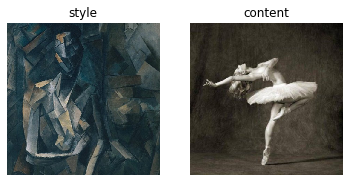

In [3]:
import matplotlib.pyplot as plt

unloader = transforms.ToPILImage()  # reconvert into PIL image

def to_img(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    return image

img_S = to_img(tensor_S)
img_C = to_img(tensor_C)

## show images in grid
fig, axes = plt.subplots(1, 2)
ax = axes.ravel()

ax[0].imshow(img_S), ax[0].set_axis_off(), ax[0].set_title('style')
ax[1].imshow(img_C), ax[1].set_axis_off(), ax[1].set_title('content')
pass

## 2. Loss Functions

In [4]:
import torch.nn as nn

class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [5]:
import torch.nn as nn
import torch.nn.functional as F

def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL
    
    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

## 3. Importing the Model

In [6]:
import torchvision.models as models

## load pretrained VGG
#cnn = models.vgg13(pretrained=True).features.eval() ## VGG-13
#cnn = models.vgg16(pretrained=True).features.eval() ## VGG-16
cnn = models.vgg19(pretrained=True).features.eval() ## VGG-19

cnn.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [7]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std  = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [8]:
# desired depth layers to compute style/content losses :
content_layers_default = ['block2_conv2']
style_layers_default = ['block1_conv1', 'block1_conv2', 'block2_conv1',
                        'block2_conv2', 'block3_conv1']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    import copy
    cnn = copy.deepcopy(cnn)
    
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle losses
    content_losses = []
    style_losses   = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)
    
    ## check each layer in CNN
    block_id = 1
    conv_id = 0
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            conv_id += 1
            name = 'block{}_conv{}'.format(block_id, conv_id)
        elif isinstance(layer, nn.ReLU):
            name = 'relu{}_{}'.format(block_id, conv_id)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'block{}_pool'.format(block_id)
            block_id += 1
            conv_id   = 0
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'block{}_bn{}'.format(block_id, conv_id)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
        
        model.add_module(name, layer)
        
        # add content loss:
        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)
        
        # add style loss:
        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)
    
    # now we trim off the layers after the last content and style losses
    for i in range(len(model)-1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses
pass

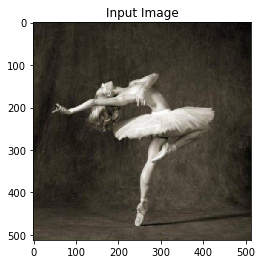

In [9]:
input_img = (tensor_C).clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(tensor_C.data.size(), device=device)

# add the original input image to the figure:
fig = plt.figure()
ax  = plt.axes()

plt.imshow(to_img(input_img))
ax.set_title('Input Image')
plt.show()

## 4. Gradient Descent

In [10]:
import torch.optim as optim

def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer


In [11]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1e6, content_weight=1e0):
    """Run the style transfer."""
    print('Building the style transfer model..')
    
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    
    optimizer = get_input_optimizer(input_img)
    
    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img


Building the style transfer model..


C:\Users\stnoh\.conda\envs\venv_pt\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
C:\Users\stnoh\.conda\envs\venv_pt\lib\site-packages\ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Optimizing..
run [50]:
Style Loss : 4.263071 Content Loss: 4.270618

run [100]:
Style Loss : 1.147024 Content Loss: 3.056195

run [150]:
Style Loss : 0.725667 Content Loss: 2.670195

run [200]:
Style Loss : 0.482588 Content Loss: 2.502800

run [250]:
Style Loss : 0.352181 Content Loss: 2.415401

run [300]:
Style Loss : 0.268535 Content Loss: 2.360345



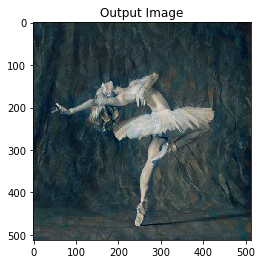

In [12]:
## with my re-defined "get_style_model_and_losses"
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            tensor_C, tensor_S, input_img)

# add the original input image to the figure:
fig = plt.figure()
ax  = plt.axes()

plt.imshow(to_img(output))
ax.set_title('Output Image')
plt.show()

In [ ]:
## export the result image
image = output.cpu().clone()  # we clone the tensor to not do changes on it
image = image.squeeze(0)      # remove the fake batch dimension
image = unloader(image)

#image.save('output.png')
pass

(end)